In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install rouge
!pip install datasketch[scipy]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 833.5 kB/s eta 0:00:00


In [ ]:
from rouge import Rouge

import transformers
import torch

import seaborn as sns

import hashlib
import datasketch
import pandas as pd
from tqdm.notebook import tqdm

In [ ]:
def hash(s: str) -> int:
    return int(hashlib.sha256(s.encode('utf-8')).hexdigest(), 16) % 10**8

In [ ]:
hash('вот такие пироги')

86581376

## Инструкции

Пример форматирования строк:

In [ ]:
example = "Эту строку мы хотим {verb}"
format_inputs = "форматировать"
example.format(verb = format_inputs)

'Эту строку мы хотим форматировать'

### Задание 1

Давайте на практике поймем, что такое системный промпт (system prompt), что такое инструкция (instruction), что такое контекст инструкции (inputs).

Ниже на английском языке даны три текста: один из них является системный промптом, другой - инструкцией (которая параметризуется контекстом), третий - контекст. Заполните переменные inputs, system_prompt и instruction с помощью переменных var_1, var_2, var_3, после чего сформируйте полный промпт. В ответе на задание укажите число - хеш от полученной строки промпта (код для хеширования указан)

In [ ]:
var_1 = "Pretend you are an student in Moscow State University. Write three reasons why do you love {inputs}.".format(inputs = var_3)
var_2 = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
var_3 = "large language models"

In [ ]:
# # Заполните системный шаблон
inputs = var_3
system_prompt = var_2
instruction = var_1

In [ ]:
prompt = """{system_prompt}

### Instruction:
{instruction}

### Response:
""".format(
    system_prompt = system_prompt,
    instruction = instruction,
)

In [ ]:
print(prompt)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Pretend you are an student in Moscow State University. Write three reasons why do you love large language models.

### Response:



In [ ]:
print('Ответ:', hash(prompt))

Ответ: 30394462


## Pretrained vs Instructed

Воспользуемся полученной инструкцией и попробуем получить полезный ответ на нее с помощью предобученной модели. Сравним, насколько хорошо с этим справляется только предобученная (без дообучения) модель gpt2, которая училась правдоподобно продолжать текст, и насколько хорошо это делает та же gpt2, дообученная на инструкции.

Далее возьмем эталонный вариант ответа на данную инструкцию и сравним, насколько генерации на нее похожи

In [ ]:
device = 'cuda'

In [ ]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
pretrained_model_name = 'gpt2'

pretrained_model = transformers.AutoModelForCausalLM.from_pretrained(
    pretrained_model_name,
    torch_dtype=torch.float16,
)

pretrained_model.to(device)

pretrained_tokenizer = transformers.AutoTokenizer.from_pretrained(pretrained_model_name)
pretrained_tokenizer.add_special_tokens({'pad_token': "<|endoftext|>"})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

1

In [ ]:
seed_everything(42)

inputs = pretrained_tokenizer(prompt, return_tensors="pt").to(device)
output = pretrained_model.generate(**inputs, max_new_tokens=64)

pretrained_output = pretrained_tokenizer.decode(output.detach()[0])
print( pretrained_output )

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Pretend you are an student in Moscow State University. Write three reasons why do you love large language models.

### Response:

Write a response that is appropriate for your situation.

### Response:

Write a response that is appropriate for your situation.

### Response:

Write a response that is appropriate for your situation.

### Response:

Write a response that is appropriate for your situation.




In [ ]:
device = 'cuda'

instructed_model_name = 'vicgalle/gpt2-open-instruct-v1'

instructed_model = transformers.AutoModelForCausalLM.from_pretrained(
    instructed_model_name,
    torch_dtype=torch.float16,
)

instructed_model.to(device)

instructed_tokenizer = transformers.AutoTokenizer.from_pretrained(instructed_model_name)

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/510M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

In [ ]:
seed_everything(42)

inputs = instructed_tokenizer(prompt, return_tensors="pt").to(device)
output = instructed_model.generate(**inputs, max_new_tokens=64)
instructed_output = instructed_tokenizer.decode(output.detach()[0])

print( instructed_output )

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Pretend you are an student in Moscow State University. Write three reasons why do you love large language models.

### Response:
1. Large language models are able to understand complex language structures and relationships.
2. Large language models are able to understand complex language structures and relationships in a more natural way.
3. Large language models are able to understand complex language structures and relationships in a more natural way by using natural language processing techniques.




In [ ]:
golden_answer = """As a student, I love large language models for several reasons:
1. Efficiency: Large language models are incredibly efficient at processing and generating text.
2. Versatility: Large language models can be used for a wide range of applications.
3. Accuracy: Large language models are highly accurate and can produce high-quality results."""

In [ ]:
class RougeMetric:
    def __init__(self):
        self.rouge = Rouge()

    def __call__(self, hypothesis: str, reference: str) -> float:
        scores = self.rouge.get_scores(hypothesis, reference)
        return scores[0]['rouge-l']['f']

rouge_wrapper = RougeMetric()

### Задание 2

Ниже посчитаны две похожести двух текстов по метрике ROUGE:
1 - похожесть сгенерированного предобученной моделью ответа на эталонный
2 - похожесть сгенерированного инструктивной моделью ответа на эталонный

Посчитайте, насколько качество инструктивной моделью по этой метрике лучше, чем качество только предобученной модели: посчитайте разность полученных метрик rouge (инструктивная минус предобученная). В качестве ответа укажите вещественное число, округленное до трех знаков

In [ ]:
print('Rouge для генерации предобученной моделью:',
      round(rouge_wrapper(pretrained_output, golden_answer), 3) )

Rouge для генерации предобученной моделью: 0.184


In [ ]:
print('Rouge для генерации инструктивной моделью:',
      round(rouge_wrapper(instructed_output, golden_answer), 3) )

Rouge для генерации инструктивной моделью: 0.244


In [ ]:
print('Ответ: ', round(rouge_wrapper(instructed_output, golden_answer) - rouge_wrapper(pretrained_output, golden_answer), 3) )

Ответ:  0.06


## Self instruct

На лекции разбирали подход self-instruct, который позволяет генерировать текстовые данные, обладающие нужными свойствами, с помощью большой языковой модели. Давайте посмотрим на один из шагов этого подхода: шаг, на котором мы подаем в llm запрос сгенерировать новый текст, похожий на предоставленные примеры

### Задание 3

Мы привели 3 примера для llm, на основании которых надо придумать четвертый и, возможно, следующие. Запустите код и посмотрите, какой новый пример сгенерировала llm. В качестве ответа укажите число - хеш от всей новой строки (с помощью кода ниже)

In [ ]:
prompt = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Below are several tasks. Continue this list of tasks:
1. Find the name for new startup with using large language models.
2. Write three arguments why do you like pancakes.
3. Describe the content in the best news article in the world.
4."""

seed_everything(42)

inputs = instructed_tokenizer(prompt, return_tensors="pt").to(device)
output = instructed_model.generate(**inputs, max_new_tokens=64)
instructed_output = instructed_tokenizer.decode(output.detach()[0])

print( instructed_output )

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Below are several tasks. Continue this list of tasks:
1. Find the name for new startup with using large language models.
2. Write three arguments why do you like pancakes.
3. Describe the content in the best news article in the world.
4. Write a blog post about the best way to learn Python.
5. Write a blog post about the best way to learn Python.
6. Write a blog post about the best way to learn Python.
7. Write a blog post about the best way to learn Python.
8. Write a blog post


In [ ]:
print(instructed_output.split('\n')[7])

4. Write a blog post about the best way to learn Python.


In [ ]:
print('Ответ: ', hash(instructed_output.split('\n')[7]))

Ответ:  79065963


## Bias Selection

Давайте на живом примере посмотрим, как выглядит bias selection, рассмотренный на лекции.
Эта концепция заключается в том, что при обычном равномерном семплировании мы с большей вероятностью выберем элемент, наиболее часто представленный в выборке.

В случае, когда мы хотим сократить размер датасета, сохранив его репрезентативность, нас интересуют как самые частые значения, так и относительно редкие, тк они, как правило, несут важную информацию о, например, разделяющей границе для классов в областях с низкой плотностью наблюдений

Ниже создается выборка, в которое заведомо число 2 встречается чаще всего, а остальные значения представлены реже. Посмотрите, что произойдет, если мы сократим выборку в 10 раз с применением обычного семплирования вместо умной дедубликации.

In [ ]:
seed_everything(42)

data = np.random.choice(np.arange(5), size=100, replace=True,
                         p = [0.1, 0.1, 0.6, 0.1, 0.1], )

In [ ]:
np.unique(data, return_counts=True)

(array([0, 1, 2, 3, 4]), array([13, 15, 54,  9,  9]))

<Axes: ylabel='Count'>

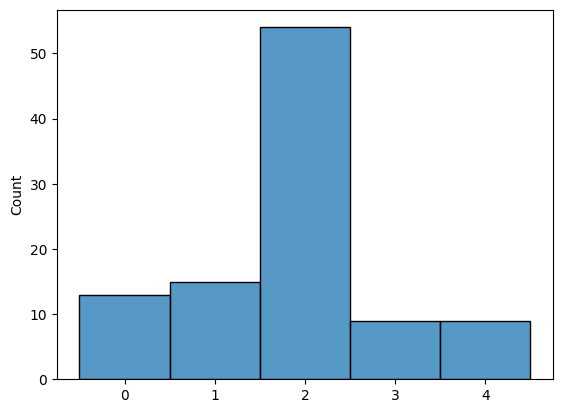

In [ ]:
sns.histplot(data, discrete=True)

In [ ]:
seed_everything(42)

sampled = np.random.choice(data, size=10, replace=False)

(array([0, 2, 3]), array([2, 6, 2]))


<Axes: ylabel='Count'>

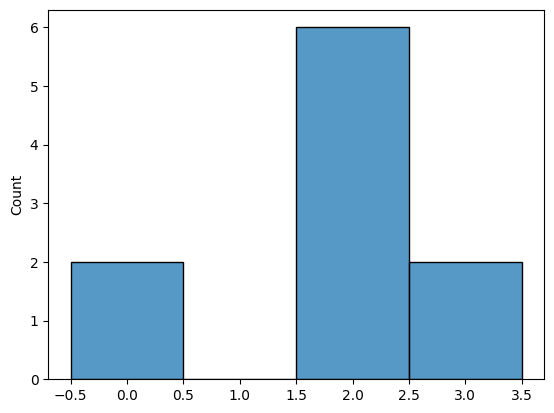

In [ ]:
print( np.unique(sampled, return_counts=True) )

sns.histplot(sampled, discrete=True)

### Задание 4

Определите, какие значения пропали из датасета после уменьшения выборки путем равномерного семплирования

Ответ дайте в виде последовательности по убыванию, записанную подряд без пробелов. Если потеряны точки 0, 1, 2, 3 и 4 то ответ будет 43210

In [ ]:
41

## MinHashLSH

Посмотрим на нечеткую дедубликацию с помощью MinHashLSH, и попробуем с помощью нее найти похожие новости (вернее, их заголовки). Это поможет нам понять, насколько датасет разнообразный, и, может быть, насколько он требует дедубликации

Используемый датасет (в kaggle можно добавить в input):
https://www.kaggle.com/datasets/vfomenko/russian-news-2020

In [47]:
input_path = '/content/drive/MyDrive/news.csv'
df = pd.read_csv(input_path)
df = df.dropna(subset=['title']).reset_index(drop=True)
print(df.shape)
df.head(2)

(21670, 7)


,source,title,text,publication_date,rubric,subrubric,tags
0,lenta.ru,Синий богатырь,В 1930-е годы Советский Союз охватила лихорадк...,2020-08-30T00:01:00+03:00,Экономика,Госэкономика,NaN
1,lenta.ru,Загитова согласилась вести «Ледниковый период»,Олимпийская чемпионка по фигурному катанию Ал...,2020-08-31T20:04:00+03:00,Спорт,Зимние виды,NaN


In [48]:
sents = df['title'].tolist()

In [60]:
seed_everything(32)

set_dict={}
norm_dict={}
count=1
for question in tqdm([x for x in sents]):
    temp_list = []
    for shingle in question.split(' '):
        temp_list.append(shingle.lower())
    set_dict["m{0}".format(count)] = set(temp_list)
    norm_dict["m{0}".format(count)] = question
    count +=1


num_perm = 128
min_dict = {}
count2 = 1
for val in tqdm(set_dict.values()):
    m = datasketch.MinHash(num_perm=num_perm)
    for shingle in val:
        m.update(shingle.encode('utf8'))
    min_dict["m{}".format(count2)] = m
    count2 += 1


lsh = datasketch.MinHashLSH(threshold=0.8, num_perm=num_perm)
for key in tqdm(min_dict.keys()):
    lsh.insert(key, min_dict[key]) # insert minhash data structure

  0%|          | 0/21670 [00:00<?, ?it/s]

  0%|          | 0/21670 [00:00<?, ?it/s]

  0%|          | 0/21670 [00:00<?, ?it/s]

In [50]:
big_list = []
for query in min_dict.keys():
    big_list.append(lsh.query(min_dict[query]))

len(big_list)

21670

In [51]:
big_list = sorted(big_list, key = lambda w: len(w), reverse=True)

In [64]:
to_show = 3
showed = 0
max_count_per_cluster = 5

for i, elems in enumerate(big_list):
    if len(elems) > 1:
        cluster_texts = [norm_dict[key] for key in elems[:max_count_per_cluster]]
        showed += 1
        if showed <= to_show:
            print(i)
            print('\n'.join(cluster_texts))
            print('\n', '=' * 30, '\n')

0
Что смотреть онлайн 6 апреля. Расписание трансляций
Что смотреть онлайн 22 апреля. Расписание трансляций
Что смотреть онлайн 19 апреля. Расписание трансляций
Что смотреть онлайн 27 апреля. Расписание трансляций
Что смотреть онлайн 18 апреля. Расписание трансляций


1
Что смотреть онлайн 10 апреля. Расписание трансляций
Что смотреть онлайн 23 апреля. Расписание трансляций
Что смотреть онлайн 16 апреля. Расписание трансляций
Что смотреть онлайн 22 апреля. Расписание трансляций
Что смотреть онлайн 27 апреля. Расписание трансляций


2
В Китае за сутки выявили восемь случаев COVID-19
В Китае за сутки выявили 26 случаев COVID-19
В Китае за сутки выявили 27 случаев COVID-19
В Китае за сутки выявили 28 случаев COVID-19
В Китае за сутки выявили 68 случаев COVID-19




### Задание 5

Выведите количество lsh-кластеров, размер которых > 1. В качестве ответа используйте целое число

In [66]:
showed

513